In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
from qiskit.ml.datasets import *
from qiskit import QuantumCircuit
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/opt/conda/lib/python3.8/site-packages/qiskit/ml/__init__.py:40: DeprecationWarning: The package qiskit.ml is deprecated. It was moved/refactored to qiskit_machine_learning (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('ml', 'qiskit_machine_learning', 'qiskit-machine-learning')


/opt/conda/lib/python3.8/site-packages/qiskit/ml/datasets/ad_hoc.py:79: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  basis = aqua_globals.random.random((2 ** n, 2 ** n)) + \


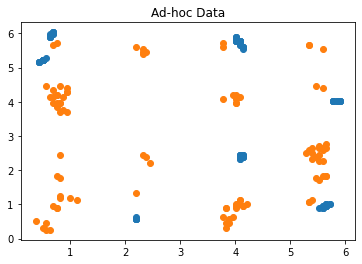

['A', 'B']


In [3]:
# size of training data set
training_size = 100
# size of test data set
test_size = 20
# dimension of data sets
n = 2
# construct training and test data
_, training_input, test_input, class_labels = ad_hoc_data(training_size=training_size, test_size=test_size, n=2, gap=0.9, plot_data=True)
print(class_labels)

/tmp/ipykernel_590/2595784837.py:4: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circuit = feature_map.combine(var_form)
/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


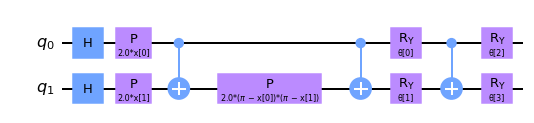

In [4]:
sv = Statevector.from_label('0' * n)
feature_map = ZZFeatureMap(n, reps=1)
var_form = RealAmplitudes(n, reps=1)
circuit = feature_map.combine(var_form)
circuit.decompose().draw(output='mpl')

In [5]:
def get_data_dict(params, x):
    parameters = {}
    for i, p in enumerate(feature_map.ordered_parameters):
        parameters[p] = x[i]
    for i, p in enumerate(var_form.ordered_parameters):
        parameters[p] = params[i]
    return parameters

In [6]:
data = [0.1, 1.2]
params = np.array([0.1, 1.2, 0.02, 0.3])
#print(get_data_dict(params, data))
#circ_ = circuit.assign_parameters(get_data_dict(params, data))
#circ_.decompose().draw(plot_barriers=True)

In [7]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

In [8]:
return_probabilities({'00' : 10, '01': 10, '11': 20}, class_labels)  

{'A': 0.75, 'B': 0.25}

In [9]:
def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circ_ = circuit.assign_parameters(get_data_dict(params, x))
        qc = sv.evolve(circ_)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict() 
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs

In [10]:
# classify a test data point
x = np.asarray([[0.5, 0.9]])
classify(x, params=np.array([0.8, -0.5, 1.5, 0.5]), class_labels=class_labels)

[{'A': 0.9123493926175841, 'B': 0.08765060738241598}]

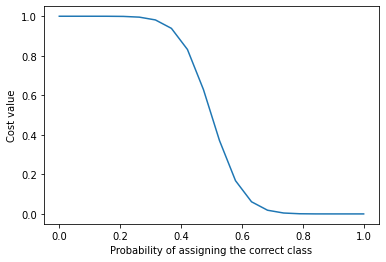

In [11]:
def cost_estimate_sigmoid(probs, expected_label): # probability of labels vs actual labels
    p = probs.get(expected_label)
    sig = None
    if np.isclose(p, 0.0):
        sig = 1
    elif np.isclose(p, 1.0):
        sig = 0
    else:
        denominator = np.sqrt(2*p*(1-p))
        x = np.sqrt(200)*(0.5-p)/denominator
        sig = 1/(1+np.exp(-x))
    return sig
x = np.linspace(0, 1, 20)
y = [cost_estimate_sigmoid({'A': x_, 'B': 1-x_}, 'A') for x_ in x]
plt.plot(x, y)
plt.xlabel('Probability of assigning the correct class')
plt.ylabel('Cost value')
plt.show()

In [12]:
def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]
# classify all samples
    probs = classify(training_samples, params, class_labels)
# evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += cost_estimate_sigmoid(prob, training_labels[i])
    cost /= len(training_samples)
# print resulting objective function
    if print_value:
        print('%.4f' % cost)
# return objective value
    return cost

cost_function(training_input, class_labels, params)

0.571758314945825

In [13]:
#Train the classifier
#Training the classifier corresponds to an optimisation task. We want to minimize the cost value
#(sigmoid function) such that the classifier manages to properly label the given data.

# setup the optimizer
optimizer = COBYLA(maxiter=100)
# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=False) 
# randomly initialize the parameters
np.random.seed(137)
init_params = 2*np.pi*np.random.rand(n*(1)*2)
# train classifier
opt_params, value, _ = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
# print results
print()
print('opt_params:', opt_params)
print('opt_value: ', value)

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',



opt_params: [8.19894213 1.41375442 4.02114925 6.05253124]
opt_value:  0.051505670592263304


----------------------------------------------------
Data point:  [4.08407045 2.32477856]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.9164052582771807, 'B': 0.08359474172281933}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.65486678 1.00530965]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.915806158695245, 'B': 0.08419384130475502}
Classification: CORRECT
----------------------------------------------------
Data point:  [2.19911486 0.56548668]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.780981331957743, 'B': 0.21901866804225698}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.78053048 4.0212386 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.7617988314922963, 'B': 0.23820116850770362}
Classification: CORRECT
----------------------------------------------------
Data point:  [5.90619419 4.0212386 ]
Label:  A
Assigned:  A
Probabilities:  {'A': 0.6966843628415835, 'B': 0.3033156371584166}
Cl

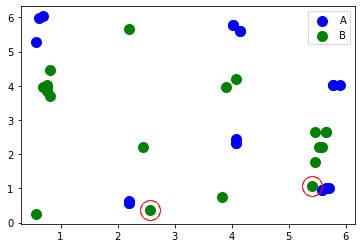

In [14]:
# Test the trained classifier
#To check how well we could train the classifier, we evaluate the classification performance on the
#test data set.
 # collect coordinates of test data
test_label_0_x = [x[0] for x in test_input[class_labels[0]]]
test_label_0_y = [x[1] for x in test_input[class_labels[0]]]
test_label_1_x = [x[0] for x in test_input[class_labels[1]]]
test_label_1_y = [x[1] for x in test_input[class_labels[1]]]
# initialize lists for misclassified datapoints
test_label_misclassified_x = []
test_label_misclassified_y = []
# evaluate test data
for label, samples in test_input.items():
# classify samples
    results = classify(samples, opt_params, class_labels)
# analyze results
    for i, result in enumerate(results):
# assign label
        assigned_label = class_labels[np.argmax([p for p in result.values()])]
        print('----------------------------------------------------')
        print('Data point: ', samples[i])
        print('Label: ', label)
        print('Assigned: ', assigned_label)
        print('Probabilities: ', result)
        if label != assigned_label:
            print('Classification:', 'INCORRECT')
            test_label_misclassified_x += [samples[i][0]]
            test_label_misclassified_y += [samples[i][1]]
        else:
            print('Classification:', 'CORRECT')
# compute fraction of misclassified samples
total = len(test_label_0_x) + len(test_label_1_x)
num_misclassified = len(test_label_misclassified_x)
print()
print(100*(1-num_misclassified/total), "% of the test data was correctly classified!")
# plot results
plt.figure()
plt.scatter(test_label_0_x, test_label_0_y, c='b', label=class_labels[0], linewidths=5)
plt.scatter(test_label_1_x, test_label_1_y, c='g', label=class_labels[1], linewidths=5)
plt.scatter(test_label_misclassified_x, test_label_misclassified_y, linewidths=20, s=1, edgecolors='r')
plt.legend()
plt.show()